In [1]:
import random
import math
import numbers
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def make_circles(grid = 10, n_data = 10):    
    max_distance = int(grid/2)
    circles = np.array([])
    distances = np.array([])
    np.random.shuffle(distances)
    radii = np.array([])
    for i in range(n_data):
        for j in range(max_distance):
            radius = np.random.randint(max_distance/2.,max_distance,size = 2)
            distance = np.random.randint(max_distance)
            distances = np.append(distances, distance)
            radii = np.append(radii, radius)
            circle = np.zeros((grid,grid))
            for k in range(2):
                r = radius[k]
                for l in range(grid):
                    for m in range(grid):
                        r = radius[k]
                        if k == 0:
                            x = l - max_distance + distance/2
                        else:
                            x = l - max_distance - distance/2
                        y = m - max_distance
                        position = math.sqrt(x**2 + y**2)
                        if position <= r:
                            p = np.exp((-1./2.)*(3.*position/r)**2.)
                            circle[l][m] += p
            circles = np.append(circles,circle)
    circles = circles.reshape(n_data*max_distance,grid**2)
    radii = radii.reshape(n_data*max_distance, 2)
    return circles, radii, distances
    

In [30]:
# TensorFlow and tf.keras
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-alpha0
2.0.0-alpha0


Make data

In [31]:
grid = 100
n_data = 10
circleData, radiiLabels, distanceLabels = make_circles(grid, n_data)

Print a plot of data to see what it looks like!

radius = 
[49. 46.]
distance between centers = 
27.0


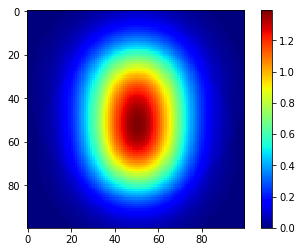

In [33]:
display = circleData[39].reshape(grid,grid)
plt.grid(False)
plt.imshow(display, cmap = 'jet')
print("radius = ")
print(radiiLabels[39])
print("distance between centers = ")
print(distanceLabels[39])
plt.colorbar()

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing

In [35]:
split = int(0.8*len(circleData))

train_data = circleData[:split]
train_labels = distanceLabels[:split]

test_data = circleData[split:]
test_labels = distanceLabels[split:]

In [36]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [37]:
model = build_model()

In [38]:
example_batch = train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.5543829],
       [1.1109273],
       [1.2036853],
       [0.938263 ],
       [1.1400741],
       [0.6381248],
       [1.1177285],
       [1.2436235],
       [1.0350225],
       [1.2965642]], dtype=float32)

In [39]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [40]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


...............................

In [41]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} distance".format(mae))

Testing set Mean Abs Error:  3.86 distance


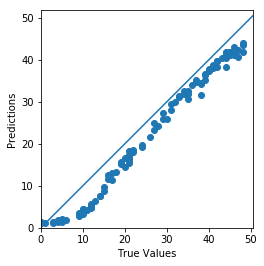

In [42]:
test_predictions = model.predict(test_data).flatten()
plt.scatter(test_labels, test_predictions)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])